In [1]:
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

In [4]:
class nltk_download:
    def __init__(self):
        pass
    def download(self):
        nltk.download("stopwords")
        self.stop_words=set(stopwords.words("english"))
        nltk.download('words')
        self.words = set(nltk.corpus.words.words())
        return self.stop_words,self.words
class twitter_sentiment:
    def __init__(self):
        self.train=None
        self.test=None
        nltk_obj=nltk_download()
        self.stop_words,self.words=nltk_obj.download()
    def preprocess(self,train,length):
        self.train=train
        #self.test=test
        self.remove_twitter_handles()
        self.remove_punctuation()
        self.remove_short_words(length)
        self.tokenize()
    def remove_pattern(self,input_txt, pattern):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    def remove_twitter_handles(self):
        #self.test['processed_sentiment'] = np.vectorize(self.remove_pattern)(self.test['tweet'], "@[\w]*")
        self.train['processed_sentiment'] = np.vectorize(self.remove_pattern)(self.train['tweet'], "@[\w]*")
    
    def remove_punctuation(self):
        #self.test['processed_sentiment'] = self.test['processed_sentiment'].str.replace("[^a-zA-Z#]", " ")
        self.train['processed_sentiment'] = self.train['processed_sentiment'].str.replace("[^a-zA-Z#]", " ")
    def  remove_short_words(self,length):
        #self.test['processed_sentiment']=self.test['processed_sentiment'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>length]))
        self.train['processed_sentiment']=self.train['processed_sentiment'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>length]))

    def preprocess_test(self,data,length):
        stemmer = PorterStemmer()
        data['processed_sentiment'] = np.vectorize(self.remove_pattern)(data['tweet'], "@[\w]*")
        data['processed_sentiment'] = data['processed_sentiment'].str.replace("[^a-zA-Z#]", " ")
        data['processed_sentiment']=data['processed_sentiment'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>length]))
        data_tokens = data['processed_sentiment'].apply(lambda x: x.split())
        data_tokens=data_tokens.apply(lambda row:self.remove_stopwords(row))
        data_tokens = data_tokens.apply(lambda x: [stemmer.stem(i) for i in x])
        for i in range(len(data_tokens)):
            data_tokens[i] = ' '.join(data_tokens[i])
        data['processed_sentiment1'] = data_tokens
        bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
        test_bow = bow_vectorizer.fit_transform(data['processed_sentiment1'])
        return test_bow
    def remove_stopwords(self,row):
        result=[]
        for elem in row:
            if elem in self.stop_words:
                pass
            else:
                result.append(elem)
        return result
    def remove_nonenglish(self,row):
        result = []
        for r in row: 
            if r in self.words: 
                result.append(r)
        return result
    def tokenize(self):
        stemmer = PorterStemmer()
        #test_tokens = self.test['processed_sentiment'].apply(lambda x: x.split())
        train_tokens=self.train['processed_sentiment'].apply(lambda x: x.split())
        train_tokens=train_tokens.apply(lambda row:self.remove_stopwords(row))
        #test_tokens=test_tokens.apply(lambda row:self.remove_stopwords(row))
        #train_tokens=train_tokens.apply(lambda row:self.remove_nonenglish(row))
        #test_tokens=test_tokens.apply(lambda row:self.remove_nonenglish(row))  
        train_tokens = train_tokens.apply(lambda x: [stemmer.stem(i) for i in x])
        #test_tokens = test_tokens.apply(lambda x: [stemmer.stem(i) for i in x])
        for i in range(len(train_tokens)):
            train_tokens[i] = ' '.join(train_tokens[i])
        '''for i in range(len(test_tokens)):
            test_tokens[i] = ' '.join(test_tokens[i])'''

        self.train['processed_sentiment1'] = train_tokens
        #self.test['processed_sentiment1'] = test_tokens
    def train_model_tfidf(self):
        tfidf_vectorizer = TfidfVectorizer( max_features=1000, stop_words='english')
        train_tfidf = tfidf_vectorizer.fit_transform(self.train['processed_sentiment1'])
        #test_tfidf = tfidf_vectorizer.fit_transform(self.test['processed_sentiment1'])
        xtrain, xval,ytrain,yval = train_test_split(train_tfidf,self.train['label'],test_size=0.50, random_state = 5)
        self.lregt = LogisticRegression()
        self.lregt.fit(xtrain,ytrain)
        prediction = self.lregt.predict_proba(xval)
        prediction_int = prediction[:,1] >= 0.3
        prediction_int = prediction_int.astype(np.int)
        print("fscore on validation set using features as tfidf")
        print(f1_score(yval, prediction_int))
        
        cnf_matrix = confusion_matrix(yval, prediction_int)
        self.plot_confusion_matrix(cnf_matrix,[0,1],normalize=True,title="Confusion matrix",model_type="tfidf")
        #predictions=self.lreg.predict(test_tfidf)
        #self.test['predictions_tfidf']=predictions
    def train_model_bow(self):
        bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
        
        train_bow = bow_vectorizer.fit_transform(self.train['processed_sentiment1'])
        #test_bow = bow_vectorizer.fit_transform(self.test['processed_sentiment1'])
        
        xtrain, xval,ytrain,yval = train_test_split(train_bow,self.train['label'],test_size=0.50, random_state = 5)
        
        self.lreg = LogisticRegression()
        self.lreg.fit(xtrain,ytrain)
        prediction = self.lreg.predict_proba(xval)
        prediction_int = prediction[:,1] >= 0.3
        prediction_int = prediction_int.astype(np.int)
        print("fscore on validation set using bag of words model as features")
        print(f1_score(yval, prediction_int))
        
        cnf_matrix = confusion_matrix(yval, prediction_int)
        self.plot_confusion_matrix(cnf_matrix,[0,1],normalize=True,title="Confusion matrix",model_type="bow")
        
        
        
        #predictions=self.lreg.predict(test_bow)
        #self.test['predictions_bow']=predictions
    def get_model_tfidf(self):
        return self.lregt
    def get_model_bow(self):
        return self.lreg
    #def get_results_bow(self):
    #    return self.test
    def plot_confusion_matrix(self,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,model_type="bow"):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        fname="confusion_matrix"+model_type
        plt.savefig(fname)
    def get_train_data(self):
        return self.train
    def get_test_data(self):
        return self.test
        

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satyam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\satyam\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
fscore on validation set using bag of words model as features
0.5494393476044852
Normalized confusion matrix
[[0.98079903 0.01920097]
 [0.52636204 0.47363796]]


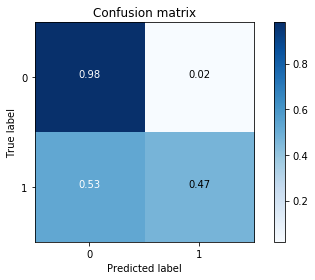

In [5]:
train=pd.read_csv('train.csv',encoding='latin-1')
test=pd.read_csv('test.csv',encoding='latin-1')
ts=twitter_sentiment()
ts.preprocess(train,2)
ts.train_model_bow()
filename="pickled_model_bow.sav"
pickle.dump(ts.get_model_bow(),open(filename,"wb"))
data=ts.preprocess_test(test,2)
model=pickle.load(open(filename,"rb"))
predictions=model.predict(data)
test['predictionsbow']=predictions

fscore on validation set using features as tfidf
0.5487674169346195
Normalized confusion matrix
[[0.98544769 0.01455231]
 [0.55008787 0.44991213]]


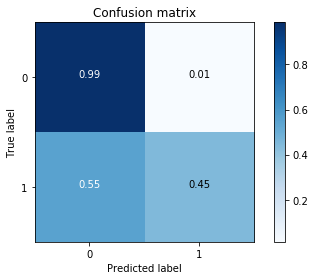

In [6]:
ts.train_model_tfidf()
filename="pickled_model_tfidf.sav"
pickle.dump(ts.get_model_bow(),open(filename,"wb"))
data=ts.preprocess_test(test,2)
model=pickle.load(open(filename,"rb"))
predictions=model.predict(data)
test['predictionstfidf']=predictions